# Tennis - REPORT + code

---

### 1. Load the necessary packages

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
from ddpg_agent import Agent
%matplotlib inline


Next, we will start the environment! The next cell code should point to the path to the executbale environment created in Unity, examples for al platforms:

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`


In [2]:
env = UnityEnvironment(file_name='../../Tennis_Windows_x86_64/Tennis_Windows_x86_64/Tennis.exe', no_graphics=True)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments to be used used through Python contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1. If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01. Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Each agent receives its own, local observation. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping.

The task is episodic, and in order to solve the environment, your agents must get an average score of +0.5 (over 100 consecutive episodes, after taking the maximum over both agents). Specifically,

After each episode, we add up the rewards that each agent received (without discounting), to get a score for each agent. This yields 2 (potentially different) scores. We then take the maximum of these 2 scores.
This yields a single score for each episode.
The environment is considered solved, when the average (over 100 episodes) of those scores is at least +0.5.

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
n_agents = len(env_info.agents)
print('Number of agents:', n_agents)

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 2
Number of actions: 2
States look like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]
States have length: 24


### 3. Instantiate a DDPG Multi-Agent

The next cell code instantiates the Agent class defined in the script **`ddpg_agent.py`**.

The Agent is reponsible of:
    - Simulating the environment's long-term rewards through Neural Netowrks forward passes
    - Accumulating experiences in a ReplayBuffer to train the networks on past situations of the environment
    - Implementing the Actor-Critic relationship as defined below to ensure a compromise between value & policy learnings

In [5]:
agents = Agent(num_agents=n_agents, state_size=state_size, action_size=action_size, random_seed=1616)

In [6]:
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 128        # minibatch size
GAMMA = 0.99            # discount factor
TAU = 2e-2              # for soft update of target parameters
LR_ACTOR = 2e-4         # learning rate of the actor 
LR_CRITIC = 2e-4        # learning rate of the critic
WEIGHT_DECAY = 0        # L2 weight decay

## The chosen hyperparameters for the learning agent are:
- BUFFER SIZE: 1e5, total size of the memory
- BATCH_SIZE: 128, # of episodes to feed from the replay memory tot he networks
- GAMMA: 0.99, discount factor of future rewards
- TAU: 2% of weights to copy during the soft update
- LEARNING RATE OF CRITIC/ACTOR: 2e-4, also managed to make it work with 1e-4 but had more "bunmps" in the reward plot
- WEIGHT DECAY: 0, no weight decaying

## Architecture of actor & critic networks:
The chosen actor & critic have the same architecture:
- 4 total layers (only 2 hidden) with 512 units on hidden layer 1 and 256 on the second one
- ReLu gates after layers 1 & 2
- Tanh gate after layer 3

Networks are kept as simple as possible not adding BatchNorm as it adds complexity and did not perform well consistently

### 4. Define the Deep Deterministic Policy Gradient algorithm to learn a policy on the environment

The DDPG algorithm pseudo-code:

![alt text](https://cdn-images-1.medium.com/max/1600/1*qV8STzz6mEYIKjOXyibtrQ.png)

We sum the rewards for each episode to measure learning. The environment is said to be solved when the average episodic reward through 100 consecutive episodes is >= 0.5

In [7]:
def ddpg(n_episodes=1000, max_t=10000, print_every=100):
    """DDPG Algorithm.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        print_every (int): frequency of printing information throughout iteration """
    # Empty lists to append individual scores
    scores = []
    scores_deque = deque(maxlen=print_every)
    # For each episode:
    for i_episode in range(1, n_episodes+1):
        # Restart the environment & the agent
        env_info = env.reset(train_mode=True)[brain_name]
        agents.reset()
        # Get the initial state
        state = env_info.vector_observations            
        score = np.zeros(n_agents)
        # For every timestep in the episode:
        for t in range(max_t):
            # Choose an action based on the learned policy
            action = agents.act(state) 
            # Get new state after chosen action
            env_info = env.step(action)[brain_name]
            next_state = env_info.vector_observations
            # Get reward from specified action
            reward = env_info.rewards     
            # Check if the episode is done
            done = env_info.local_done
            # Learning!
            agents.step(state, action, reward, next_state, done) 
            # Accumulate score & set up next state
            score += reward                                
            state = next_state                             
            if np.any(done):                                       
                break
        # Accumulate scores to check whether env. is solved or not
        scores_deque.append(np.mean(score))      
        scores.append(np.mean(score))            

        print('\rEpisode {}\tAverage Score: {:.4f}'.format(i_episode, np.mean(scores_deque)), end="")
        
        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.4f}'.format(i_episode, np.mean(scores_deque)))
            torch.save(agents.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agents.critic_local.state_dict(), 'checkpoint_critic.pth')
        
        if np.mean(scores_deque)>=0.5:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.4f}'.format(i_episode, np.mean(scores_deque)))
            torch.save(agents.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agents.critic_local.state_dict(), 'checkpoint_critic.pth')
            break
            
    return scores

Episode 100	Average Score: -0.0040
Episode 200	Average Score: -0.0025
Episode 300	Average Score: 0.02655
Episode 400	Average Score: 0.2466
Episode 474	Average Score: 0.5046
Environment solved in 474 episodes!	Average Score: 0.5046


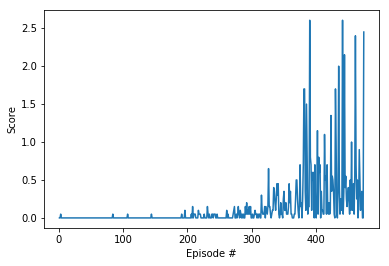

In [8]:
scores = ddpg(n_episodes = 10000)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [9]:
#env.close()

Now let's run it in a test environment to check if it actually learned anything:

In [ ]:
agents.actor_local.load_state_dict(torch.load('checkpoint_actor.pth'))
agents.critic_local.load_state_dict(torch.load('checkpoint_critic.pth'))
# Change with real path to the Reacher with visualization enbaled to see it in action!
env = UnityEnvironment('../../Tennis_Windows_x86_64/Tennis_Windows_x86_64/Tennis.exe')
state = env.reset()
for t in range(200):
    action = agents.act(state, add_noise=False)
    env.render()
    state, reward, done, _ = env.step(action)
    if done:
        break 

env.close()

### 5. Future work

Future improvements of the Agent could include:
- MADDPG as the learning algorithm
- prioritized experience replay
- using raw pixels as input instead of state vector